Trabajo ejemplo tomado del curso de Inteligencia Artificial IA2023II. El ejemplo está construido con un conjunto de datos disponible en Kaggle: https://www.kaggle.com/datasets/fedesoriano/gisette-dataset-mnist-digits-4-and-9/data

# Gisette Dataset (MNIST digits 4 and 9)
En el actual notebook se encuentra el código necesario para realizar los diferentes métodos de Machine Learning:
* Arbol de decisión
* Random Forest
* Redes Neuronales
* Redes Neuronales Profundas

## Descipción del problema
El problema de **GISETTE** es un problema de reconocimiento de dígitos escritos a mano. Es un problema de clasificación el cual consiste en separar los dígitos '4' y '9', que son altamente confusos.


Este dataset fue usado originalmente en un taller de NIPS (Neural Information Processing Systems), una conferencia en la que llegan varios investigadores de distintas partes del mundo a dar charlas, que usualmente son seguidas por un taller en el que varios grupos de investigadores participan en una competencia para ver quien puede puede proponer el mejor algoritmo de **feature selection**. 

Los autores a los que se le atribuye la publicación del dataset son:
* Isabelle Guyon
* Steve Gunn
* Asa Ben-Hur
* Gideon Dror

Para esta implementación utilizaremos la versión modificada por un usuario de Kaggle llamado *fedesoriano*, que la ha montado en la misma plataforma. Su trabajo fue el de reunir todas las imagenes y Labels en el mismo archivo para posteriormente convertirlas en un archivo pickle, de manera que sea mas fácil de acceder y cargar los datos para su uso. El dataset está disponible en el [siguiente link](https://www.kaggle.com/datasets/fedesoriano/gisette-dataset-mnist-digits-4-and-9/data).

Los dígitos y datos originales fueron preprocesados, ya que las imágenes de los dígitos fueron todas normalizadas a un tamaño de 28x28 pixeles. Los siguientes son ejemplos de las imágenes:

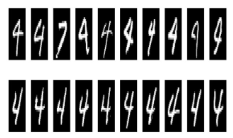

Sin embargo, solamente se usaron ciertos píxeles de la parte superior central de la imagen (muestreados al azar) para crear este dataset y por último se crearon nuevas características multiplicando los valores de algunos pixeles para aumentar la dimensionalidad.

El reto que nos propone el dataset es construir un algoritmo de aprendizaje automático que sea capaz de seleccionar las características apropiadas, ya que el conjunto de datos incluye un total de 5000 características de las cuales 2500 no tienen poder predictivo.

## Contenido del dataset
Para poder realizar una visualización de los datos necesitaremos las siguientes librerías:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import tree, ensemble, neural_network
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Como los datos se encuentran en el archivo gisette.pickle, tenemos que exportar los datos.

In [2]:
gisette_data = pd.read_pickle(r'gisette.pickle')
gisette_data

{'training': {'data': array([[550.,   0., 495., ...,   0.,   0., 983.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0., 991., ...,   0.,   0., 991.]]),
  'labels': array([ 1., -1.,  1., ..., -1., -1., -1.])},
 'validation': {'data': array([[688.,   0.,   0., ...,   0., 769.,   0.],
         [778., 758.,   0., ...,   0.,   0.,   0.],
         [469.,   0., 816., ..., 417.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0., 742.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
  'labels': array([ 1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
          1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
          1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,
         -1.,

Confirmamos que los datos están guardados en forma de diccionario

In [3]:
type(gisette_data)

dict

Mostramos las llaves de este diccionario.

In [4]:
gisette_data.keys()

dict_keys(['training', 'validation', 'testing'])

Estas contienen otra llave que separa los datos puros de sus Labels o variable a predecir, a excepción de la de testing.

In [5]:
print('Training keys: ',gisette_data['training'].keys())
print('Validation keys: ',gisette_data['validation'].keys())
print('Testing keys: ',gisette_data['testing'].keys())

Training keys:  dict_keys(['data', 'labels'])
Validation keys:  dict_keys(['data', 'labels'])
Testing keys:  dict_keys(['data'])


Recapitulando, este dataset nos devuelve un diccionario, el cual contiene 3 claves: **training**, **validation** y **testing**. Cada una de estas claves tiene su valor, en la que cada valor son los datos o características representados como **data** y la variable a predecir llamada **labels** a excepción de **testing** que simplemente tiene los datos y no la variable a predecir. 

En este caso la variable a predecir o **labels** representan si es un 4 o un 9, por lo cual si *label=-1* representa al dígito 9 y si *label=1* representa al dígito 4. Ya que el resultado es binario, es decir solo puede ser 1 o -1, nos encontramos con un problema de **clasificación**, en el que nuestros algoritmos tienen que predecir el valor de una variable discreta.

Se observa igualmente que los datos que nos proporciona el dataset para entrenar, validar y testear el modelo tienen diferentes ejemplos o filas. Sin embargo, para testear el modelo, utilizaremos los datos que nos proporciona *validation* ya que los datos de *testing* no tienen una variable a predecir, y nuestra intención es realizar un aprendizaje supervisado.

In [6]:
print('Examples of training data:',len(gisette_data['training']['data']))
print('Examples of validation data:',len(gisette_data['validation']['data']))
print('Examples of testing data:',len(gisette_data['testing']['data']))

Examples of training data: 6000
Examples of validation data: 1000
Examples of testing data: 6500


## Análisis de los datos
Para poder analizar los datos, utilizaremos el conjunto de datos de **training** y lo convertiremos a un objeto de tipo DataFrame. Luego se muestra información importante sobre los datos.

Como las carácteristicas que tenemos en este conjunto de datos no tienen algún nombre, ya que son un *color de escala de grises* pertenecientes a un *pixel cualquiera*, y estos pixeles que nos entrega están desordenados, decidimos colocarle el nombre genérico de "feature_x" a cada carácteristica donde x es el orden en el que aparecen al visualizar la tabla. Por último agregamos la columna de los Labels al final para su visualización.

In [20]:
training_data = gisette_data['training']['data']
training_labels = gisette_data['training']['labels']
# Convertir los datos en un objeto de tipo DataFrame de la libreria Pandas
X = pd.DataFrame(data=training_data, columns=['feature_'+str(i) for i in range(len(training_data[0]))])
X['labels'] = training_labels
# Se muestra la información de los datos
X.info(verbose=True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5001 columns):
 #     Column        Non-Null Count  Dtype  
---    ------        --------------  -----  
 0     feature_0     6000 non-null   float64
 1     feature_1     6000 non-null   float64
 2     feature_2     6000 non-null   float64
 3     feature_3     6000 non-null   float64
 4     feature_4     6000 non-null   float64
 5     feature_5     6000 non-null   float64
 6     feature_6     6000 non-null   float64
 7     feature_7     6000 non-null   float64
 8     feature_8     6000 non-null   float64
 9     feature_9     6000 non-null   float64
 10    feature_10    6000 non-null   float64
 11    feature_11    6000 non-null   float64
 12    feature_12    6000 non-null   float64
 13    feature_13    6000 non-null   float64
 14    feature_14    6000 non-null   float64
 15    feature_15    6000 non-null   float64
 16    feature_16    6000 non-null   float64
 17    feature_17    6000 non-null  

Aquí podemos ver que no hay algun dato nulo o faltante en el conjunto, lo cual es muy conveniente ya que nos ayuda a omitir gran parte de los pasos de limpieza de datos.

Igualmente, veremos unos datos adicionales que nos proporciona la libería *Pandas* al utilizar uno de sus métodos, el cual nos permitirá tener un mejor entendimiento de los datos ahora que los podemos visualizar.

In [8]:
X.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4991,feature_4992,feature_4993,feature_4994,feature_4995,feature_4996,feature_4997,feature_4998,feature_4999,labels
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,111.022833,11.251000,173.261167,0.951000,15.169167,50.209333,15.206333,323.073167,2.207667,146.355667,...,111.407500,2.035333,318.539667,81.03950,44.777333,263.813667,14.720667,122.423500,153.636000,0.000000
std,284.848291,91.448864,341.759463,25.771877,109.238579,194.682629,106.963813,418.413159,39.746428,317.863306,...,276.658528,41.781918,420.830651,256.10652,185.273192,394.966054,106.994417,294.247413,326.609648,1.000083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,786.000000,0.000000,0.000000,...,0.000000,0.000000,790.250000,0.00000,0.000000,659.250000,0.000000,0.000000,0.000000,1.000000
max,999.000000,999.000000,999.000000,983.000000,999.000000,999.000000,999.000000,999.000000,991.000000,999.000000,...,999.000000,999.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000,999.000000,1.000000


El conjunto de datos que hemos puesto en el dataframe contiene en total 5000 características, representadas en este caso desde el pixel 0 al pixel 4999(nombrados arbitrariamente, sin seguir algún orden) y en la columna 5000 el valor de label(Variable a predecir) en cada respectivo ejemplo.

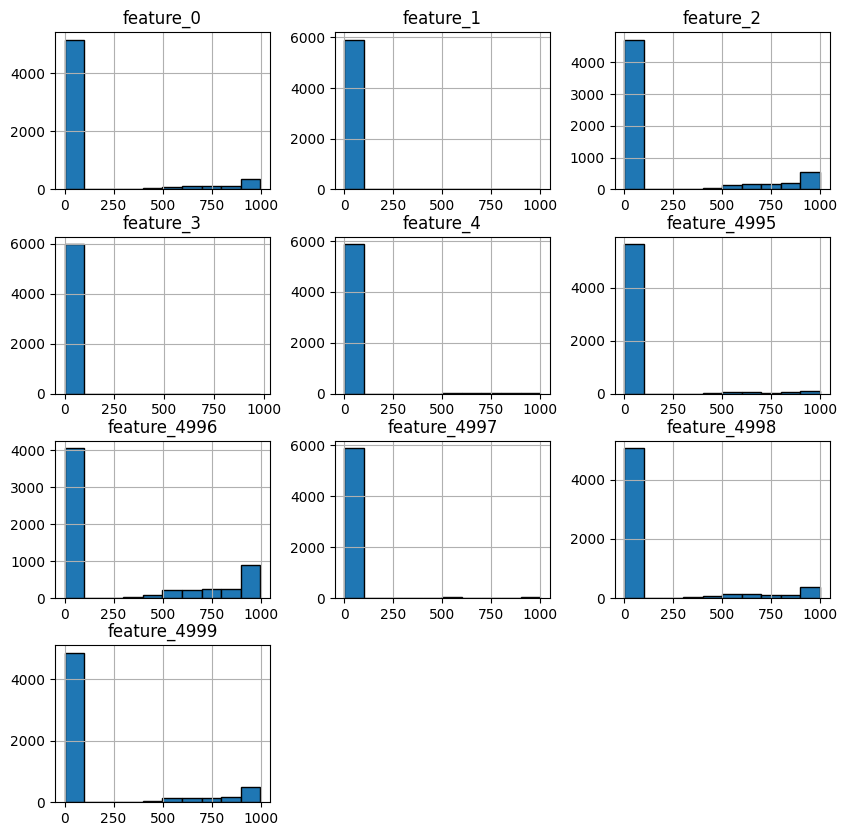

In [54]:
X.hist(['feature_0','feature_1','feature_2','feature_3','feature_4',
        'feature_4995','feature_4996','feature_4997','feature_4998','feature_4999'],edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Observando los histogramas de las primeras 5 características y las 5 últimas, se puede observar que en todos los casos los datos **no** están normalmente distribuidos, lo que nos indica que muy posiblemente ninguna de las características del dataset tiene los datos distribuidos normalmente debido a la similitud de los datos que componen los ejemplos mostrados arriba.

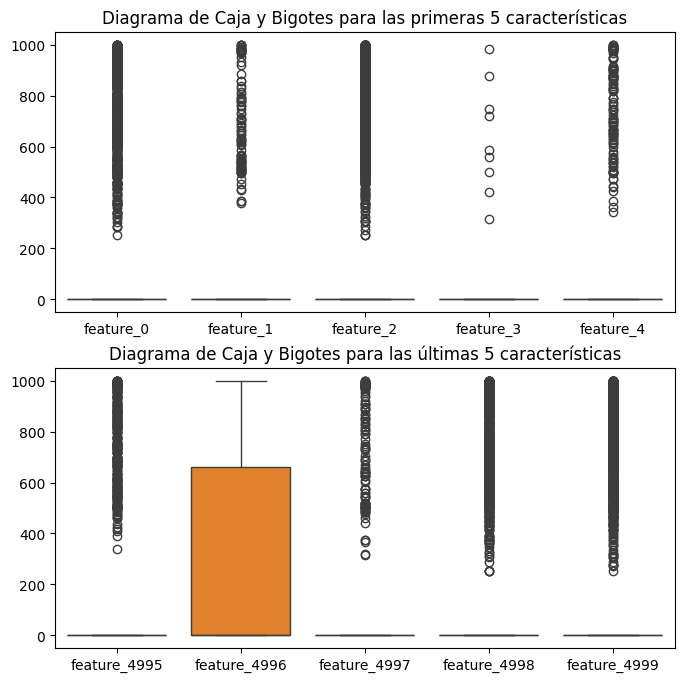

In [14]:
fig, axs = plt.subplots(2,1,figsize=(8,8))
sns.boxplot(data=X[['feature_0','feature_1','feature_2','feature_3','feature_4']],ax=axs[0])
axs[0].set_title('Diagrama de Caja y Bigotes para las primeras 5 características')
sns.boxplot(data=X[['feature_4995','feature_4996','feature_4997','feature_4998','feature_4999']],ax=axs[1])
axs[1].set_title('Diagrama de Caja y Bigotes para las últimas 5 características')
plt.show()

Como se puede ver en los diagramas de caja y bigote anteriores, hay **muchos datos atípicos** y aunque los datos sean muchos, hay poca dispersión entre ellos.

## Distribución de las Clases
Visualizando la distribución de las clases a través de un histograma.

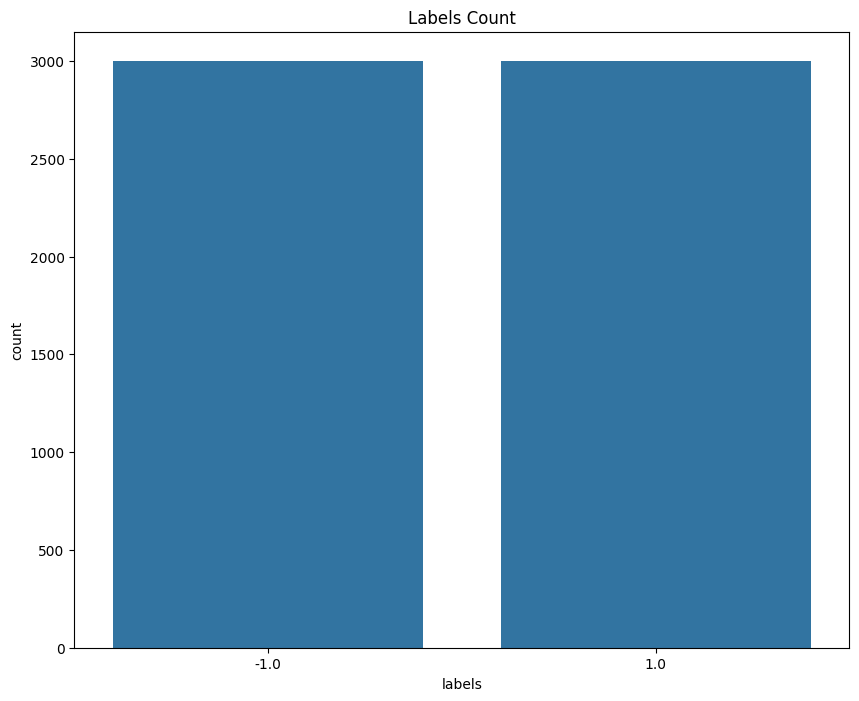

In [10]:
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(data=X, x="labels")
plt.title("Labels Count")
plt.show()

Nuestro conjunto de datos de entrenamiento tiene 6000 ejemplos, el gráfico de arriba nos permite saber que nuestro conjunto de datos se encuentra balanceado debido a que cada clase tiene 3000 ejemplos.

## Feature Engineering
Antes de realizar las pruebas de feature engineering convertiremos nuestros datos de prueba al objeto de tipo *Dataframe* que nos ofrece la librería *Pandas*, para poderlo usar junto con los datos de entrenamiento.

In [16]:
validation_data = gisette_data['validation']['data']
y_validation = gisette_data['validation']['labels']

X_validation = pd.DataFrame(data=validation_data, columns=['feature_'+str(i) for i in range(len(validation_data[0]))])
X_validation['labels'] = y_validation
X_validation

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4991,feature_4992,feature_4993,feature_4994,feature_4995,feature_4996,feature_4997,feature_4998,feature_4999,labels
0,688.0,0.0,0.0,0.0,0.0,0.0,0.0,952.0,0.0,870.0,...,0.0,0.0,0.0,0.0,0.0,494.0,0.0,769.0,0.0,1.0
1,778.0,758.0,0.0,0.0,0.0,0.0,0.0,708.0,0.0,991.0,...,0.0,0.0,770.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,469.0,0.0,816.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,467.0,0.0,0.0,0.0,417.0,0.0,0.0,-1.0
3,0.0,0.0,0.0,0.0,0.0,571.0,991.0,983.0,0.0,983.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,949.0,0.0,991.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,976.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,511.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,852.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
996,0.0,0.0,599.0,0.0,0.0,0.0,0.0,910.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,707.0,1.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,742.0,1.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,968.0,0.0,0.0,...,0.0,0.0,773.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


Luego, separamos las variables predictoras de las variables a predecir

In [17]:
X_train = X.drop(['labels'], axis=1) # Separa las variables predictoras de las variable a predecir
y_train = X['labels']

X_test = X_validation.drop(['labels'],axis=1)
y_test = X_validation['labels']

**IMPORTANTE**

**Tener en mente los nombre de las pruebas que se encuentran a continuación, de la 1 a la 3, ya que son los que vamos a utilizar para referirnos a las diferentes configuraciones a lo largo de todo el texto (Ejemplo: Sin embargo, con la Prueba 1 hemos concluido que...)** 

### Prueba 1
En esta prueba aplicaremos solamente el método de Principal Component Analysis (PCA) para poder realizar una reducción de la dimensionalidad evaluando que la varianza de los datos se conserve.

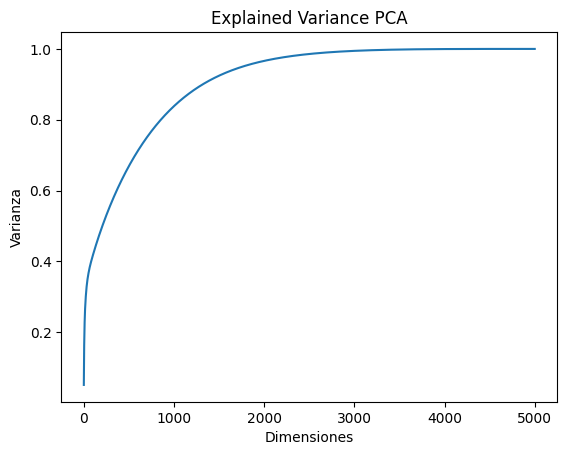

In [21]:
# Principal Component Analysis
pca = PCA()

X_train_PCA = pca.fit_transform(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel('Dimensiones')
plt.ylabel('Varianza')
plt.title("Explained Variance PCA")
plt.show()
train_index = range(0,len(X_train))
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

El gráfico nos muestra que a medida de que crece el tamaño de la muestra de datos la varianza sube, sin embargo *despúes de un cierto punto* el aumento es *muy mínimo* y nos deja la opción de recortar el tamaño de la muestra sin perder mucha varianza. A continuación evaluaremos la varianza de todo el conjunto de datos de entrenamiento.

In [22]:
# Percentage of Variance Captured by 5000 principal components
print("Variance Explained by all 5000 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 5000 principal components:  0.9999999999999994


La varianza es *muy alta*, aproximándose a 1 lo cual es algo muy beneficioso. Es hora de ver explícitamente cual es la cantidad de la varianza al hacer recortes de varios tamaños.

In [23]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 1000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:999].sum(axis=1).values)
print('Variance Captured by First 1500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:1499].sum(axis=1).values)
print('Variance Captured by First 2000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:1999].sum(axis=1).values)
print('Variance Captured by First 2500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:2499].sum(axis=1).values)
print('Variance Captured by First 3000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:2999].sum(axis=1).values)
print('Variance Captured by First 3500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:3499].sum(axis=1).values)

Variance Captured by First 1000 Principal Components:  [0.83827664]
Variance Captured by First 1500 Principal Components:  [0.92441109]
Variance Captured by First 2000 Principal Components:  [0.96620063]
Variance Captured by First 2500 Principal Components:  [0.98569556]
Variance Captured by First 3000 Principal Components:  [0.99453533]
Variance Captured by First 3500 Principal Components:  [0.99826127]


Como se puede observar las varianzas a partir de 3500 datos en adelante ya son muy cercanas a 1, por lo que podríamos aplicar una reducción de la dimensionalidad de los datos.

En este caso, realizaremos una **reducción de 2500 dimensiones** o características ya que al eliminarlas podemos observar que la varianza sigue, de todas formas, siendo cercana a 1, lo que es una muy buena opción.

In [24]:
pca = PCA(n_components=2500)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,10625.490378,2640.714856,6733.280600,8270.670175,1052.453861,-1268.286528,2136.147281,2995.585036,-2717.134945,3821.922620,...,72.336029,-34.392925,-29.746234,-124.812316,16.638403,-2.556940,-91.226709,-77.644302,130.239997,260.096859
1,5046.238859,-5301.992984,-4247.276014,-2492.178743,194.714529,453.653399,-571.140707,4750.232961,127.713598,1509.927317,...,83.600286,-67.011676,58.199376,-39.473633,59.621144,122.456167,-37.709213,-46.675605,-59.001422,44.264230
2,1814.154499,-5894.792481,-2199.482361,2353.499823,3805.579323,-1156.720641,748.739064,-1887.485214,1264.444842,2083.392791,...,-67.728451,22.024349,28.623955,-48.801716,-192.899516,-74.070847,8.555010,125.249278,68.108767,34.238265
3,4029.656430,-698.929215,95.233834,-2731.711253,2911.977481,-4642.479910,-1369.477445,2814.959907,-1506.103560,-296.072679,...,-86.297989,-54.566560,-20.813416,144.903840,112.578221,-130.195926,-62.394122,-116.400143,-18.524501,-62.834419
4,-5245.527368,475.361630,815.049564,-144.896441,-1065.833262,716.204011,-710.111986,-1606.667073,-1134.278057,-900.596161,...,-53.658562,20.978684,33.749190,18.112858,-55.837992,-104.565937,41.085963,-22.048527,-100.374617,-120.791037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-2232.530331,2903.425664,-2139.586195,-1989.168746,1036.238436,-906.768239,609.273121,-858.406282,233.767713,2601.705092,...,11.390263,-101.426703,-141.568862,66.583186,-34.731299,109.348284,2.571459,176.941091,114.591723,-2.804303
5996,-3210.592532,1263.522049,149.225021,4161.845139,-780.867347,650.869990,-3466.330484,335.227646,-282.304989,-2333.403824,...,9.490170,6.974852,96.029877,93.029623,-86.003576,74.923506,106.007307,-82.147273,-91.996899,-67.061297
5997,875.082297,-5584.875465,-2768.445532,-1023.469035,-512.926243,2012.906319,-3582.173132,3099.537879,201.573706,110.640599,...,160.537588,-69.786500,72.501822,40.714191,-50.239737,-6.195511,197.158427,-60.012698,75.471082,7.433618
5998,-1065.712792,-4327.673850,2537.088454,-938.046345,-330.796766,-612.323790,-1430.262026,-693.794464,1026.712826,-131.405789,...,61.321936,86.784202,-54.125452,139.477248,-148.274218,34.084944,25.600192,94.786045,68.004516,28.753944


Ahora que pudimos realizar la reducción de dimensionalidad por medio de PCA, vamos a comparar los datos de las primeras 2 carácteristicas del dataframe para evaluar si hay mas dispersión al usar PCA, contra la dispersión que se observa en el conjunto de datos sin alteraciones.

c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


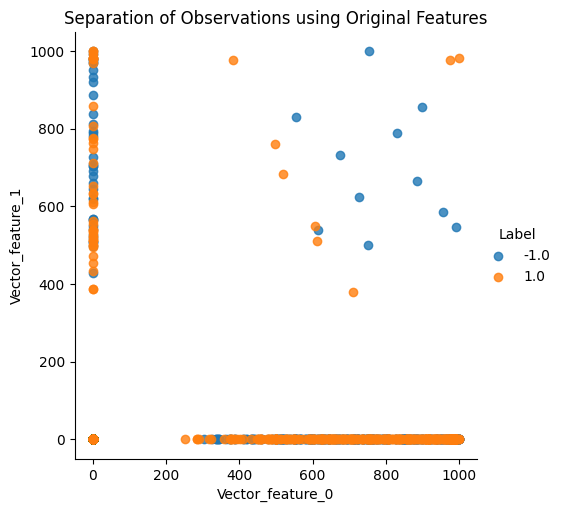

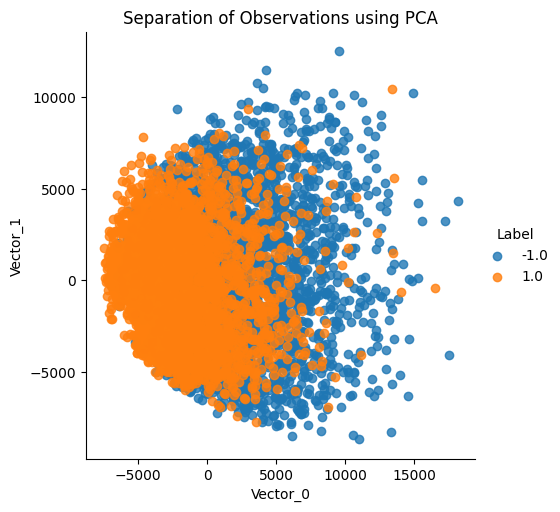

In [25]:
def scatterPlot(xDF, yDF, algoName, col1, col2):
    tempDF = pd.DataFrame(data=xDF.loc[:,[col1,col2]], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    v1 = f"Vector_{col1}"
    v2 = f"Vector_{col2}"
    tempDF.columns = [v1, v2, "Label"]
    sns.lmplot(x=v1, y=v2, hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

scatterPlot(X_train, y_train, "Original Features", 'feature_0', 'feature_1')
scatterPlot(X_train_PCA, y_train, "PCA", 0, 1)

Pudimos gracias a PCA conservar una buena dispersión de los datos y reducir el tamaño de la muestra, lo que nos ayudará a futuro a tener un mejor desempeño computaiconal. Ya eliminadas las dimensiones de nuestro dataset de entrenamiento, tenemos que transformar igualmente los datos que utilizaremos para testear el modelo, por lo que utilizaremos los mismos egenvectores creados anteriormente en nuestro PCA para convertir nuestros datos

In [27]:
X_validation_PCA = pca.transform(X_test)
validation_index = range(0,len(X_test))
X_validation_PCA = pd.DataFrame(data=X_validation_PCA, index=validation_index)
X_validation_PCA

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,-803.888690,-3037.055967,-3523.337816,-749.396375,2514.678447,711.547801,677.346349,-1453.532295,3443.612862,-1271.466222,...,-88.737942,-23.945604,98.263956,-182.727386,193.590760,-85.146222,60.369852,115.076225,-99.557025,40.921867
1,-3792.161778,1733.063694,1863.417378,3315.044262,320.421031,6299.942971,-425.161966,-1926.443426,888.168743,544.846398,...,-195.715950,-145.926565,126.959593,284.961333,129.644596,4.687077,-73.019454,394.205056,-61.315511,71.321250
2,-2094.614492,4248.354006,-4356.378938,-1866.296383,3433.079856,227.263773,2633.290316,-319.199298,444.948828,538.111454,...,-126.375241,81.278413,-182.530341,-64.171491,54.003379,-86.260884,-1.107773,-172.876151,50.058872,-101.002325
3,-2959.662707,-1297.261396,-364.368436,2079.135031,-1390.801318,-3738.134639,-1625.804610,1721.081058,-3496.279560,1390.072397,...,93.093244,-39.542100,79.491639,-184.856258,17.771229,-119.649234,11.217217,-121.377335,-133.541089,142.897894
4,-4183.689977,-2822.237482,-203.459795,1010.009601,-614.553813,-3413.042264,-232.506897,1366.180554,-548.925615,-435.283611,...,92.159431,-316.932031,193.995876,18.176744,-141.363420,-68.856639,160.545329,68.832460,8.495846,141.099074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1701.653682,-1496.392050,-4706.788349,-2587.262066,-1185.458548,1424.773715,1223.014999,-1410.624274,-1311.138773,-2635.645293,...,-50.273554,217.151918,-4.496737,-40.627444,-58.982541,-39.089348,26.002219,-124.385420,61.622518,-10.729028
996,3246.894530,-798.948861,5298.153452,-324.153008,6074.735915,4022.526997,5269.206357,-5067.112590,-929.870582,-16.671301,...,142.113437,-135.264497,-19.630019,-122.960289,73.271472,-219.239790,-93.585594,-86.895306,20.855693,464.578664
997,-205.806891,5363.290338,5143.201032,667.650743,-3713.705459,1442.718870,5000.201648,-2393.327830,653.529140,277.730351,...,6.737768,28.844777,257.417130,12.067050,226.321050,-29.571124,-275.383858,73.935700,-50.093928,120.031393
998,-177.125146,-3771.959878,-1333.895517,-2414.677511,-3758.326116,1461.779098,-1652.138342,1765.732570,-385.419763,575.854876,...,-248.463682,36.338401,-58.927677,-157.862102,135.643557,-108.860414,33.887523,46.562161,103.743192,-148.832753


### Prueba 2
En esta prueba aplicaremos solamente un método de selección de características, específicamente el método de filtro aplicando correlación, por medio del cual eliminaremos las variables que menos correlación tengan con la variable a predecir.

Para seleccionar el tipo de correlación que utilizaremos hay que tener en cuenta los datos que tenemos. Como sabemos que los datos originales no están normalmente distribuidos y tienen muchos valores atípicos, la correlación de Pearson no nos serviría.

Esto nos deja dos opciones, el modelo de *Spearman* o el de *Kendall*.

En este caso **seleccionaremos Spearman** por cuatro principales razones:
1. El método de *Kendall* es mucho más preciso cuando se tiene un conjunto de datos pequeños.
2. El método de *Kendall* a comparación de Spearman tiene mucho más costo computacional, lo cual es un obstáculo considerando que no tenemos equipos de alta gama.
3. El método de *Kendall* es usualmente utilizado para medir la correlación entre dos variables cualitativas o discretas.
4. El método de *Kendall* funciona peor que el de Spearman si hay varios datos iguales en la muestra.

In [46]:
fs = pd.DataFrame(X_train)
fs['target'] = y_train
corr_matrix = fs.corr(method='spearman')
corr_matrix = corr_matrix.abs().unstack()
corr_target = corr_matrix['target'].sort_values(ascending=False) 
corr_target

target          1.000000
feature_3656    0.651181
feature_557     0.633529
feature_3975    0.607280
feature_511     0.572074
                  ...   
feature_4100         NaN
feature_4255         NaN
feature_4388         NaN
feature_4872         NaN
feature_4964         NaN
Length: 5001, dtype: float64

Al obtener ya las correlaciones tomaremos un umbral de 0.15 para seleccionar las características que más nos discriminen las clases en el conjunto de datos al tener una mayor correlación con la variable a predecir.

In [47]:
features_selected = corr_target[corr_target > 0.15]
features_selected

target          1.000000
feature_3656    0.651181
feature_557     0.633529
feature_3975    0.607280
feature_511     0.572074
                  ...   
feature_2808    0.151112
feature_4788    0.151071
feature_742     0.150988
feature_1084    0.150632
feature_4474    0.150382
Length: 548, dtype: float64

Tomamos con este umbral 548 características, lo que nos reduce considerablemente el número de características que teníamos inicialmente, eliminaremos estas características de los datos de entrenamiento y de prueba para poder entrenar nuestro modelo más adelante

In [49]:
X_train_fs = X_train[features_selected.index.drop("target")]
X_test_fs = X_test[features_selected.index.drop("target")]
X_train_fs

,feature_3656,feature_557,feature_3975,feature_511,feature_2742,feature_4507,feature_3002,feature_904,feature_4195,feature_4271,...,feature_1462,feature_291,feature_649,feature_3837,feature_66,feature_2808,feature_4788,feature_742,feature_1084,feature_4474
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,509.0,...,0.0,0.0,579.0,0.0,991.0,983.0,983.0,983.0,509.0,991.0
1,995.0,991.0,987.0,987.0,983.0,991.0,960.0,862.0,925.0,925.0,...,0.0,0.0,0.0,0.0,442.0,0.0,0.0,991.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,592.0,885.0,0.0,0.0,863.0,...,0.0,0.0,0.0,0.0,987.0,976.0,0.0,614.0,0.0,0.0
3,991.0,995.0,851.0,987.0,987.0,991.0,956.0,0.0,745.0,742.0,...,742.0,742.0,983.0,731.0,0.0,987.0,859.0,0.0,610.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,780.0,0.0,630.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,940.0,807.0,483.0,564.0,570.0,870.0,0.0,0.0,804.0,0.0,...,0.0,0.0,0.0,0.0,987.0,0.0,0.0,0.0,991.0,0.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,995.0,917.0,0.0,991.0,913.0,995.0,995.0,901.0,525.0,536.0,...,0.0,0.0,0.0,0.0,0.0,991.0,0.0,768.0,0.0,0.0
5998,956.0,0.0,0.0,952.0,0.0,991.0,991.0,789.0,0.0,0.0,...,0.0,0.0,0.0,0.0,913.0,663.0,498.0,956.0,0.0,0.0


### Prueba 3
Para esta prueba realizaremos en primer lugar la reducción de la dimensionalidad de los datos a través de PCA y luego realizaremos una selección de características a través del método de filtro con correlación.

Como ya convertimos los datos a PCA anteriormente y eliminamos 2500 dimensiones de nuestros datos, realizamos ahora un análisis de la distribución de los datos convertidos para saber que método de correlación que utilizaremos más adelante.

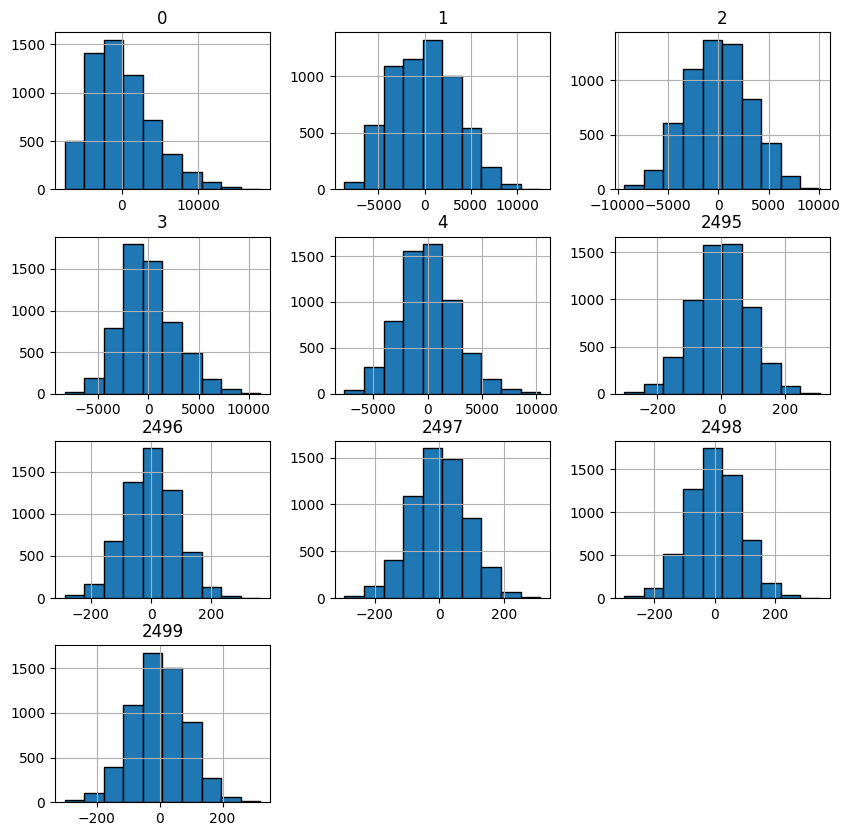

In [51]:
X_train_PCA.hist([0,1,2,3,4,2495,2496,2497,2498,2499],edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Como se puede observar, con estas 10 componentes de prueba, nuestros datos están normalmente distribuidos debido a que nuestros histogramas tienen forma de *campana de Gauss*, sin embargo, para asegurarnos realizaremos otra gráfica.

Ahora realizaremos un diagrama de caja y bigotes de los primeros 5 componentes y los últimos 5 componentes para asegurarnos que nuestros datos estén normalmente distribuidos.

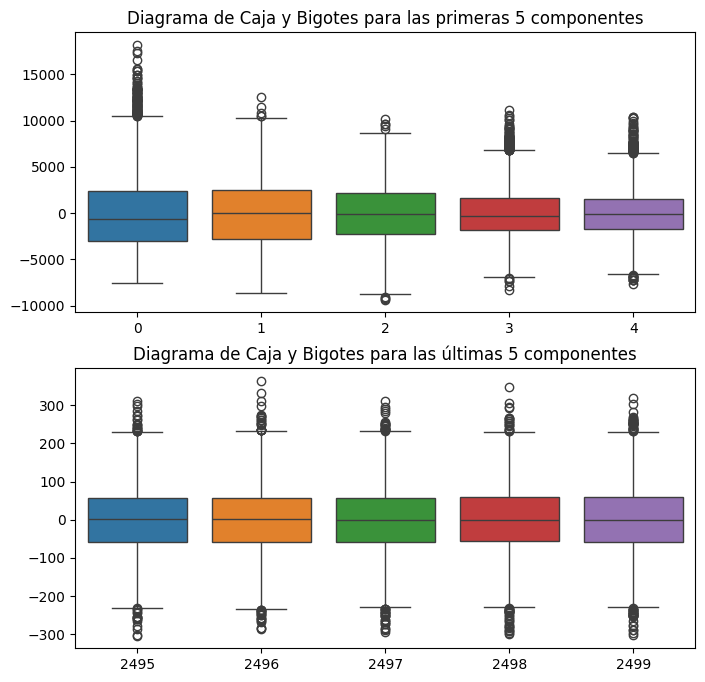

In [55]:
fig, axs = plt.subplots(2,1,figsize=(8,8))
sns.boxplot(data=X_train_PCA[[0,1,2,3,4]],ax=axs[0])
axs[0].set_title('Diagrama de Caja y Bigotes para las primeras 5 componentes')
sns.boxplot(data=X_train_PCA[[2495,2496,2497,2498,2499]],ax=axs[1])
axs[1].set_title('Diagrama de Caja y Bigotes para las últimas 5 componentes')
plt.show()

Al observar que todos nuestros componentes están normalmente distribuidos, nos damos cuenta de que podríamos utilizar el método de correlación de Pearson, ya que anteriormente determinamos que el de Pearson funciona con este tipo de conjunto de datos.

In [56]:
fs = pd.DataFrame(X_train_PCA)
fs['target'] = y_train
corr_matrix = fs.corr(method='pearson')
corr_matrix = corr_matrix.abs().unstack()
corr_target = corr_matrix['target'].sort_values(ascending=False) 
corr_target

target    1.000000
3         0.519353
0         0.448178
6         0.302564
2         0.198668
            ...   
2221      0.000016
1194      0.000015
1393      0.000011
1474      0.000005
1886      0.000004
Length: 2501, dtype: float64

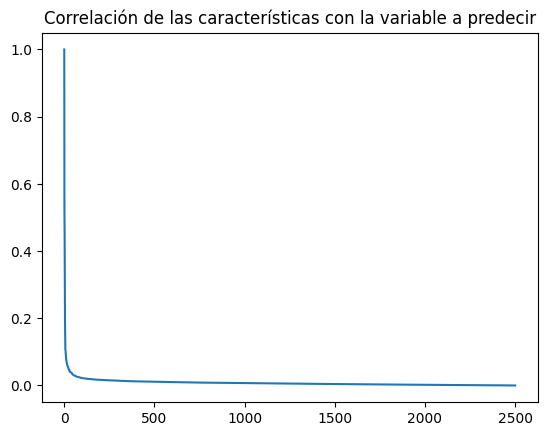

In [57]:
plt.plot(corr_target.values)
plt.title("Correlación de las características con la variable a predecir")
plt.show()

De modo visual deducimos que existen aproximadamente 2000 características que tienen una correlación muy aproximada a 0 con respecto a la variable a predecir, por lo tanto, eliminaremos 2000 características.

Para confirmar lo anterior, seleccionaremos un umbral de 0.05, seleccionando las características que si tienen correlación con la variable a predecir, eliminando por completo las que no afectarían considerablemente la clasificación.

In [66]:
features_selected = corr_target[corr_target > 0.05]
features_selected

target    1.000000
3         0.519353
0         0.448178
6         0.302564
2         0.198668
5         0.135054
24        0.108033
11        0.104255
41        0.095944
13        0.088576
19        0.081457
1         0.075082
35        0.074664
16        0.070115
4         0.066038
15        0.064939
39        0.063276
10        0.059341
43        0.058289
26        0.056896
18        0.056647
73        0.054935
46        0.051964
14        0.051295
dtype: float64

Hecho esto, se obtiene de la selección un total de 23 características. Por consiguiente, seleccionaremos las 23 características tanto en los datos de entrenamiento como en los datos de prueba para entrenar el modelo.

In [67]:
X_train_PCA_fs = X_train_PCA[features_selected.index.drop("target")]
X_test_PCA_fs = X_validation_PCA[features_selected.index.drop("target")]
X_train_PCA_fs

,3,0,6,2,5,24,11,41,13,19,...,4,15,39,10,43,26,18,73,46,14
0,8270.670175,10625.490378,2136.147281,6733.280600,-1268.286528,-1406.301230,1313.350402,-588.915281,1146.643281,387.494460,...,1052.453861,-1865.469280,1066.607550,1461.061080,-236.412145,739.242967,-230.614451,321.068057,-774.005874,-1899.055199
1,-2492.178743,5046.238859,-571.140707,-4247.276014,453.653399,-1489.220502,1054.749914,1057.942031,1017.496281,1186.080159,...,194.714529,-105.218385,221.340780,-2415.996819,227.315445,-149.280313,-2069.004027,79.225575,701.692762,1461.812117
2,2353.499823,1814.154499,748.739064,-2199.482361,-1156.720641,-1186.023920,-1008.621964,-199.411849,1384.901581,1612.143898,...,3805.579323,-2031.469975,-1621.904793,1823.112377,186.807358,410.327023,524.281102,350.416818,-970.279323,-75.840149
3,-2731.711253,4029.656430,-1369.477445,95.233834,-4642.479910,-199.918401,4209.479324,-230.578256,-770.218086,923.424031,...,2911.977481,-2369.553082,-1606.072738,3464.529759,-846.553962,1471.525189,2007.711872,1332.027858,516.534019,448.782016
4,-144.896441,-5245.527368,-710.111986,815.049564,716.204011,-703.698297,-1643.948054,495.439771,2166.517129,99.118034,...,-1065.833262,957.047040,-416.089414,-385.936985,-182.458263,791.343009,-1130.508592,218.778946,-716.887216,-1300.328295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-1989.168746,-2232.530331,609.273121,-2139.586195,-906.768239,-660.517713,-3368.104604,-247.072925,2185.611001,-101.898283,...,1036.238436,-154.953727,823.928337,-462.088789,-1076.878091,-1086.969136,498.020592,-109.148379,-137.104540,292.961228
5996,4161.845139,-3210.592532,-3466.330484,149.225021,650.869990,233.308085,606.438931,-27.348387,2735.453881,-1015.082343,...,-780.867347,-62.226767,-133.874523,90.113010,-821.568351,40.511921,1251.566916,-571.739422,167.866253,-902.346757
5997,-1023.469035,875.082297,-3582.173132,-2768.445532,2012.906319,-1028.998876,253.844120,-281.351245,-804.560354,1105.647616,...,-512.926243,147.827879,178.838035,-63.034722,907.779033,-1793.310161,168.818511,-309.761399,-225.508324,-618.797084
5998,-938.046345,-1065.712792,-1430.262026,2537.088454,-612.323790,604.036904,-1005.522910,1633.519057,-2375.195507,173.578303,...,-330.796766,1720.879632,-373.040578,-1708.391960,50.160657,1996.662870,-1263.504731,-742.491039,-96.743528,1063.838647


## Pruebas de eficacia
Para probar la eficiencia y comparar los resultados las 3 pruebas realizadas anteriomente entrenaremos 3 tipos de modelos, Arboles de Decisión, Random Forest y Redes Neuronales, cada uno de estos tendrá 3 modelos diferentes de prueba que equivalen a los que mostramos anteriormente.

Todos los modelos tendrán los parámetros por defecto para tener igualdad de condiciones.

**Arbol de decisiones**

In [75]:
#Entrenamiento de los 3 modelos, 1 para cada prueba que se realizó
clf_PCA = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf_fs = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf_PCA_fs = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')

clf_PCA = clf_PCA.fit(X_train_PCA,y_train)
clf_fs = clf_fs.fit(X_train_fs,y_train)
clf_PCA_fs = clf_PCA_fs.fit(X_train_PCA_fs,y_train)

#Evaluación en el conjunto de prueba
y_pred_PCA = clf_PCA.predict(X_validation_PCA)
y_pred_fs = clf_fs.predict(X_test_fs)
y_pred_PCA_fs = clf_PCA_fs.predict(X_test_PCA_fs)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(clf_PCA.score(X_train_PCA, y_train)))
print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf_PCA.score(X_validation_PCA, y_test)))
print("Matriz de confusión PCA:")
print(confusion_matrix(y_test, y_pred_PCA))
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(clf_fs.score(X_train_fs, y_train)))
print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf_fs.score(X_test_fs, y_test))) 
print("Matriz de confusión FS:")
print(confusion_matrix(y_test, y_pred_fs))
print('=========================== ACCURACY WITH PCA & FS ===========================')
print('Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(clf_PCA_fs.score(X_train_PCA_fs, y_train)))
print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf_PCA_fs.score(X_test_PCA_fs, y_test))) 
print("Matriz de confusión PCA & FS:")
print(confusion_matrix(y_test, y_pred_PCA_fs))

=========================== ACCURACY WITH PCA ===========================
Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.86
Matriz de confusión PCA:
[[434  66]
 [ 70 430]]
=========================== ACCURACY WITH FS ===========================
Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.94
Matriz de confusión FS:
[[475  25]
 [ 38 462]]
=========================== ACCURACY WITH PCA & FS ===========================
Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.89
Matriz de confusión PCA & FS:
[[440  60]
 [ 48 452]]


**Random Forest**

In [73]:
rf_PCA = ensemble.RandomForestClassifier(criterion='entropy')
rf_fs = ensemble.RandomForestClassifier(criterion='entropy')
rf_PCA_fs = ensemble.RandomForestClassifier(criterion='entropy')

rf_PCA = rf_PCA.fit(X_train_PCA,y_train)
rf_fs = rf_fs.fit(X_train_fs,y_train)
rf_PCA_fs = rf_PCA_fs.fit(X_train_PCA_fs,y_train)

#Evaluación en el conjunto de prueba
y_pred_PCA = rf_PCA.predict(X_validation_PCA)
y_pred_fs = rf_fs.predict(X_test_fs)
y_pred_PCA_fs = rf_PCA_fs.predict(X_test_PCA_fs)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(rf_PCA.score(X_train_PCA, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(rf_PCA.score(X_validation_PCA, y_test)))
print("Matriz de confusión PCA:")
print(confusion_matrix(y_test, y_pred_PCA))
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(rf_fs.score(X_train_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(rf_fs.score(X_test_fs, y_test))) 
print("Matriz de confusión FS:")
print(confusion_matrix(y_test, y_pred_fs))
print('=========================== ACCURACY WITH PCA & FS ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(rf_PCA_fs.score(X_train_PCA_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(rf_PCA_fs.score(X_test_PCA_fs, y_test))) 
print("Matriz de confusión PCA & FS:")
print(confusion_matrix(y_test, y_pred_PCA_fs))

=========================== ACCURACY WITH PCA ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.88
Matriz de confusión PCA:
[[433  67]
 [ 54 446]]
=========================== ACCURACY WITH FS ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.97
Matriz de confusión FS:
[[492   8]
 [ 20 480]]
=========================== ACCURACY WITH PCA & FS ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.96
Matriz de confusión PCA & FS:
[[479  21]
 [ 19 481]]


**Redes neuronales**

In [76]:
# Se realiza el escalamiento de los datos para que el modelo converja más rápido
min_max_scaler = preprocessing.MinMaxScaler()

X_train_PCA_scaler = min_max_scaler.fit_transform(X_train_PCA)
X_validation_PCA_scaler = min_max_scaler.fit_transform(X_validation_PCA)

X_train_fs_scaler = min_max_scaler.fit_transform(X_train_fs)
X_test_fs_scaler = min_max_scaler.fit_transform(X_test_fs)

X_train_PCA_fs_scaler = min_max_scaler.fit_transform(X_train_PCA_fs)
X_test_PCA_fs_scaler = min_max_scaler.fit_transform(X_test_PCA_fs)

In [77]:
mlp_PCA = neural_network.MLPClassifier()
mlp_fs = neural_network.MLPClassifier()
mlp_PCA_fs = neural_network.MLPClassifier()

mlp_PCA = mlp_PCA.fit(X_train_PCA_scaler,y_train)
mlp_fs = mlp_fs.fit(X_train_fs_scaler,y_train)
mlp_PCA_fs = mlp_PCA_fs.fit(X_train_PCA_fs_scaler,y_train)

#Evaluación en el conjunto de prueba
y_pred_PCA = mlp_PCA.predict(X_validation_PCA_scaler)
y_pred_fs = mlp_fs.predict(X_test_fs_scaler)
y_pred_PCA_fs = mlp_PCA_fs.predict(X_test_PCA_fs_scaler)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(mlp_PCA.score(X_train_PCA_scaler, y_train)))
print('Accuracy de MLPClassifier sobre el conjunto de prueba es: {:.2f}'.format(mlp_PCA.score(X_validation_PCA_scaler, y_test)))
print("Matriz de confusión PCA:")
print(confusion_matrix(y_test, y_pred_PCA))
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(mlp_fs.score(X_train_fs_scaler, y_train)))
print('Accuracy de MLPClassifier sobre el conjunto de prueba es: {:.2f}'.format(mlp_fs.score(X_test_fs_scaler, y_test))) 
print("Matriz de confusión FS:")
print(confusion_matrix(y_test, y_pred_fs))
print('=========================== ACCURACY WITH PCA & FS ===========================')
print('Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(mlp_PCA_fs.score(X_train_PCA_fs_scaler, y_train)))
print('Accuracy de MLPClassifier sobre el conjunto de prueba es: {:.2f}'.format(mlp_PCA_fs.score(X_test_PCA_fs_scaler, y_test))) 
print("Matriz de confusión PCA & FS:")
print(confusion_matrix(y_test, y_pred_PCA_fs))

c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


=========================== ACCURACY WITH PCA ===========================
Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de MLPClassifier sobre el conjunto de prueba es: 0.90
Matriz de confusión PCA:
[[497   3]
 [ 97 403]]
=========================== ACCURACY WITH FS ===========================
Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de MLPClassifier sobre el conjunto de prueba es: 0.98
Matriz de confusión FS:
[[491   9]
 [ 14 486]]
=========================== ACCURACY WITH PCA & FS ===========================
Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: 0.97
Accuracy de MLPClassifier sobre el conjunto de prueba es: 0.85
Matriz de confusión PCA & FS:
[[499   1]
 [144 356]]


Cada modelo cuenta con su correspondiente accuracy y matriz de confusión de acuerdo a la configuración de prueba utilizada, veremos estos resultados mas a fondo.

**Comparación en los 3 métodos**: A continuación se hace una comparación de los 3 métodos según el accuracy que recibió la predicción con el conjunto de prueba de cada modelo.

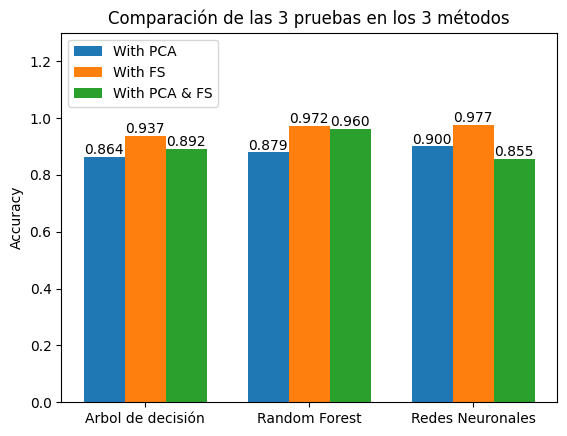

In [81]:
clf_score_PCA = clf_PCA.score(X_validation_PCA, y_validation)
clf_score_fs = clf_fs.score(X_test_fs, y_validation)
clf_score_PCA_fs = clf_PCA_fs.score(X_test_PCA_fs, y_validation)
rf_score_PCA = rf_PCA.score(X_validation_PCA, y_validation)
rf_score_fs = rf_fs.score(X_test_fs, y_validation)
rf_score_PCA_fs = rf_PCA_fs.score(X_test_PCA_fs, y_validation)
mlp_score_PCA = mlp_PCA.score(X_validation_PCA_scaler, y_validation)
mlp_score_fs = mlp_fs.score(X_test_fs_scaler, y_validation)
mlp_score_PCA_fs = mlp_PCA_fs.score(X_test_PCA_fs_scaler, y_validation)

fig, ax = plt.subplots()
rects1=ax.bar(np.arange(3)-0.25,[clf_score_PCA,rf_score_PCA,mlp_score_PCA],0.25,label="With PCA")
rects2=ax.bar(np.arange(3),[clf_score_fs,rf_score_fs,mlp_score_fs],0.25,label="With FS")
rects3=ax.bar(np.arange(3)+0.25,[clf_score_PCA_fs,rf_score_PCA_fs,mlp_score_PCA_fs],0.25,label="With PCA & FS")

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, '%.3f' % height, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["Arbol de decisión","Random Forest","Redes Neuronales"])
ax.legend(loc='upper left')
ax.set_ylim(0, 1.3)
plt.title("Comparación de las 3 pruebas en los 3 métodos")

plt.show()

Como se puede observar utilizando los modelos de Machine Learning el accuracy es mejor en todos los casos cuando se realiza solamente selección de características (Prueba 2), por lo cual, se procederá a realizar las pruebas de aquí en adelante con el conjunto de datos de prueba 2 que tiene 547 características. Además cabe aclarar que si realizamos solamente un proceso de reducción de dimensionalidad (Prueba 1) el modelo puede quedar un poco sobreajustado, ya que en nuestro entrenamiento tenemos un accuracy de 1.0 y al momento de usar los datos de prueba tenemos un accuracy menor o igual a 0.9 en todos los casos.

El modelo que usa ambos PCA y Feature Selection(Prueba 3) logra quedar en segundo puesto en todos los casos excepto el de redes neuronales, este no es un mal resultado, sin embargo realizando el proceso de *feature selection* solamente (Prueba 2), nuestro accuracy mejora considerablemente con respecto al resto y se obtiene un valor muy cercano a 1.0 lo que garantiza un buen desempeño del modelo.

## Decision Tree
### Prueba con parámetros por defecto
Como anteriormente se realizó el entrenamiento del modelo con los parámetros por defectos, veremos el score, el reporte de clasificación y la matriz de confusión utilizando la configuración de Prueba 2 (FS).

In [82]:
print('Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: {:.3f}'.format(clf_fs.score(X_train_fs, y_train)))
print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.3f}'.format(clf_fs.score(X_test_fs, y_validation)))

Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: 1.000
Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.937


Aquí podemos ver que la precisión se mantiene incluso al evaluar el conjunto de prueba.

In [83]:
# Validación cruzada
cross_val_scores = cross_val_score(clf_fs, X_train_fs, y_train, cv=5)
print("Resultados de la validación cruzada:")
print(cross_val_scores)
print("Precisión media: {:.2f}".format(cross_val_scores.mean()))

Resultados de la validación cruzada:
[0.94083333 0.93       0.93333333 0.9475     0.93666667]
Precisión media: 0.94


Utilizando una validación cruzada con 5 particiones, obtenemos que la precisión media al usar varias particiones de prueba sigue aproximándose a 1.

In [84]:
y_pred_test = clf_fs.predict(X_test_fs)
y_pred_train = clf_fs.predict(X_train_fs)

print("Reporte de clasificación entrenamiento: ")
print(classification_report(y_train, y_pred_train))
print("==============================================================")
print("Reporte de clasificación prueba: ")
print(classification_report(y_validation, y_pred_test))

Reporte de clasificación entrenamiento: 
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      3000
         1.0       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Reporte de clasificación prueba: 
              precision    recall  f1-score   support

        -1.0       0.93      0.95      0.94       500
         1.0       0.95      0.92      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



Tanto la accuracy, como el recall y el f1 nos dan resultados muy favorables.

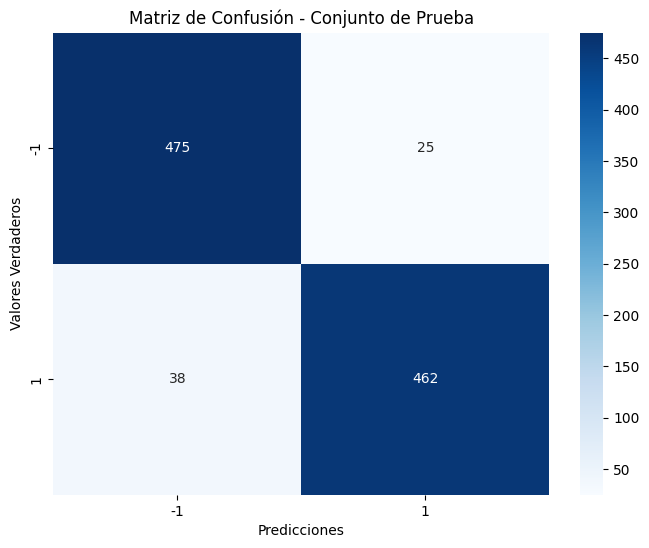

In [85]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

Como se puede observar en la matriz de confusión, el modelo de Decision Tree clasifica muy bien los datos de prueba, tendiendo a equivocarse ligeramente más detectando los verdaderos positivos que pertenecen a la clasificación 1(son un nueve). Sin embargo por motivos de optimización, lo someteremos a una serie de pruebas para encontrar los mejores hiperparámetros posibles.

### Pruebas de parámetros con GridSearch
**PRUEBA 1**

Utilizaremos varias configuraciones distintas de hiperparámetros para probar el modelo de DecisionTreeClassifier(Que se va a correr 128 veces en total) para encontrar los hiperparámetros optimos.

In [144]:
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf':[2, 4, 6, 8]}

model = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid,cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train_fs, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [2, 4, 6, 8],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [145]:
best_params_clf1 = grid_search.best_params_
print(best_params_clf1)
score_clf1 = grid_search.best_score_
print("Best score:",score_clf1)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 8}
Best score: 0.943


Arriba podemos ver la mejor configuración obtenida por el algoritmo.

In [147]:
predictions = grid_search.predict(X_test_fs)
print("Accuracy:",accuracy_score(y_validation, predictions))

Accuracy: 0.933


In [148]:
y_pred_train = grid_search.predict(X_train_fs)
y_pred_test  = grid_search.predict(X_test_fs)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_validation, y_pred_test))

              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97      3000
         1.0       0.97      0.97      0.97      3000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000

----------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.93      0.94      0.93       500
         1.0       0.94      0.93      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



Los resultados siguen siendo favorables, pero quiz'as se podrían mejorar.

**PRUEBA 2**

Realizamos a continuación otra prueba más sobre DecisionTree con nuevos hiperparámetros.

In [149]:
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth': [None, 15, 20, 50],
    'min_samples_split' : [5, 7, 9, 10],
    'min_samples_leaf':[5, 7, 9]}

model = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid,cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train_fs, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 15, 20, 50],
                         'min_samples_leaf': [5, 7, 9],
                         'min_samples_split': [5, 7, 9, 10]},
             scoring='accuracy')

In [150]:
best_params_clf2 = grid_search.best_params_
print(best_params_clf2)
score_clf2 = grid_search.best_score_
print("Best score:",score_clf2)

{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 9, 'min_samples_split': 9}
Best score: 0.9433333333333334


Arriba podemos ver la mejor configuración obtenida por el algoritmo.

In [151]:
predictions= grid_search.predict(X_test_fs)
print("Accuracy:",accuracy_score(y_validation, predictions))

Accuracy: 0.936


In [152]:
y_pred_train = grid_search.predict(X_train_fs)
y_pred_test  = grid_search.predict(X_test_fs)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_validation, y_pred_test))

              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.97      3000
         1.0       0.97      0.96      0.97      3000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000

----------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.92      0.96      0.94       500
         1.0       0.95      0.92      0.93       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



Los resultados presentan mejorías minimas en otras areas, pero podrían mejorar aún más.

**PRUEBA 3**

Realizamos La última prueba sobre DecisionTree con nuevos hiperparámetros.

In [153]:
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth': [150,200,500],
    'min_samples_split' : [10, 12, 15, 20],
    'min_samples_leaf':[10, 12, 15, 20]}

model = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid,cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train_fs, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [150, 200, 500],
                         'min_samples_leaf': [10, 12, 15, 20],
                         'min_samples_split': [10, 12, 15, 20]},
             scoring='accuracy')

In [154]:
best_params_clf3 = grid_search.best_params_
print(best_params_clf3)
score_clf3 = grid_search.best_score_
print("Best score:",score_clf3)

{'criterion': 'entropy', 'max_depth': 150, 'min_samples_leaf': 12, 'min_samples_split': 20}
Best score: 0.9445


Arriba podemos ver la mejor configuración obtenida por el algoritmo.

In [155]:
predictions = grid_search.predict(X_test_fs)
print("Accuracy:",accuracy_score(y_validation, predictions))

Accuracy: 0.928


In [156]:
y_pred_train = grid_search.predict(X_train_fs)
y_pred_test  = grid_search.predict(X_test_fs)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_validation, y_pred_test))

              precision    recall  f1-score   support

        -1.0       0.97      0.97      0.97      3000
         1.0       0.97      0.97      0.97      3000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000

----------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.91      0.94      0.93       500
         1.0       0.94      0.91      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



Para saber cual de estas tres configuraciones es la mejor, compararemos también de manera visual

**Comparación con 3 pruebas y parámetros por defecto**

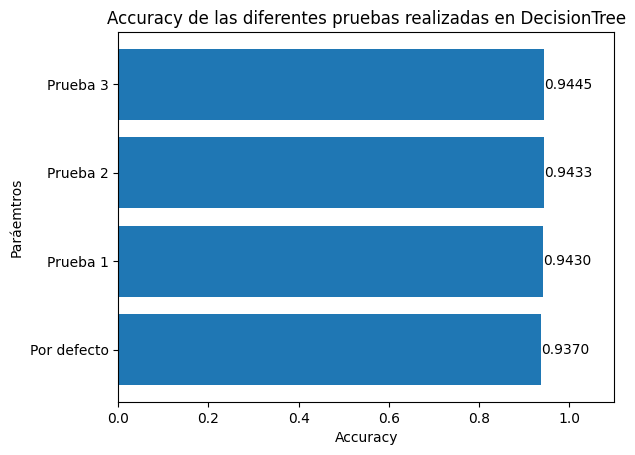

In [158]:
accuracys=[clf_fs.score(X_test_fs, y_validation),
           score_clf1,
           score_clf2,
           score_clf3]
pruebas = ["Por defecto", "Prueba 1", "Prueba 2", "Prueba 3"]

fig, ax = plt.subplots()
bars = ax.barh(pruebas,accuracys)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Paráemtros')
ax.set_title('Accuracy de las diferentes pruebas realizadas en DecisionTree')
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.4f}', 
             va='center', ha='left')
ax.set_xlim(0, 1.1)
plt.show()

Aquí podemos observar que gracias a GridSearch nuestro modelo mejora(Aunque de manera mínima) respecto a la configuración que incluye la librería por defecto.

## Random Forest
### Pruebas con parámetros por defecto
Como anteriormente se realizó el entrenamiento del modelo con los parámetros por defecto, veremos el score, el reporte de clasificación y la matriz de confusión.

In [90]:
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.3f}'.format(rf_fs.score(X_train_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.3f}'.format(rf_fs.score(X_test_fs, y_validation)))

Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.000
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.972


In [91]:
y_pred_test = rf_fs.predict(X_test_fs)
y_pred_train = rf_fs.predict(X_train_fs)

print("Reporte de clasificación entrenamiento: ")
print(classification_report(y_train, y_pred_train))
print("==============================================================")
print("Reporte de clasificación prueba: ")
print(classification_report(y_validation, y_pred_test))

Reporte de clasificación entrenamiento: 
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      3000
         1.0       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Reporte de clasificación prueba: 
              precision    recall  f1-score   support

        -1.0       0.96      0.98      0.97       500
         1.0       0.98      0.96      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Notamos que en RandomForest los resultados son muy buenos a pesar de que estamos utilizando la configuración por defecto.

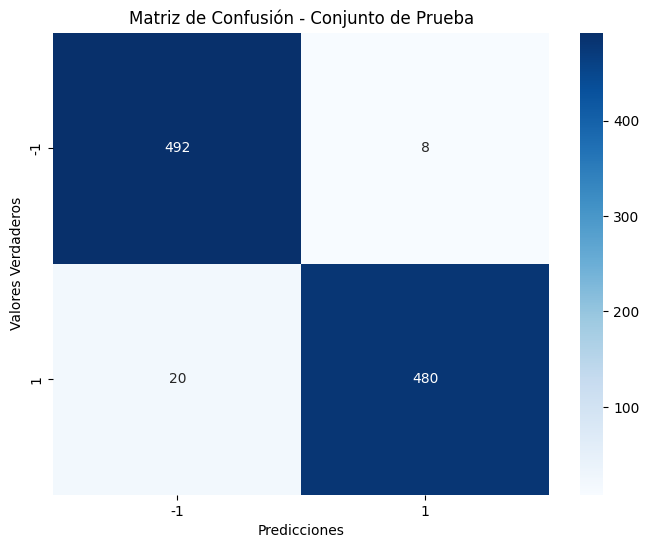

In [92]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

La matriz de confusión indica el alto rendimiento del modelo, con tan solo 8 falsos positivos sobre la clasificación -1(es un cuatro), pero...podría mejorar?

### Pruebas de parámetros con GridSearch
Con fines de eficiencia computacional, realizaremos una sola prueba de GridSearch con suficientes hiperparámetros para poder tomar el mejor score y los mejores parámetros, este algoritmo se ejecutará 800 veces, lo cual toma un buen rato.

In [159]:
param_grid = {
    'n_estimators': [50,100,200,300,500],
    'criterion' : ['gini','entropy'],
    'max_depth': [None, 10, 20, 100,300],
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf':[1, 2, 4, 6]}

model = ensemble.RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(model, param_grid,cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train_fs, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 100, 300],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [50, 100, 200, 300, 500]},
             scoring='accuracy')

In [160]:
best_params_rf = grid_search.best_params_
print(best_params_rf)
score_rf = grid_search.best_score_
print("Best score:",score_rf)

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score: 0.9745000000000001


Arriba podemos ver la mejor configuración obtenida por el algoritmo.

In [162]:
predictions = grid_search.predict(X_test_fs)
print("Accuracy:",accuracy_score(y_validation, predictions))

Accuracy: 0.973


In [163]:
y_pred_train = grid_search.predict(X_train_fs)
y_pred_test  = grid_search.predict(X_test_fs)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_validation, y_pred_test))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      3000
         1.0       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

----------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.96      0.98      0.97       500
         1.0       0.98      0.96      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Los resultados siguen siendo muy satisfactorios.

**Comparación**

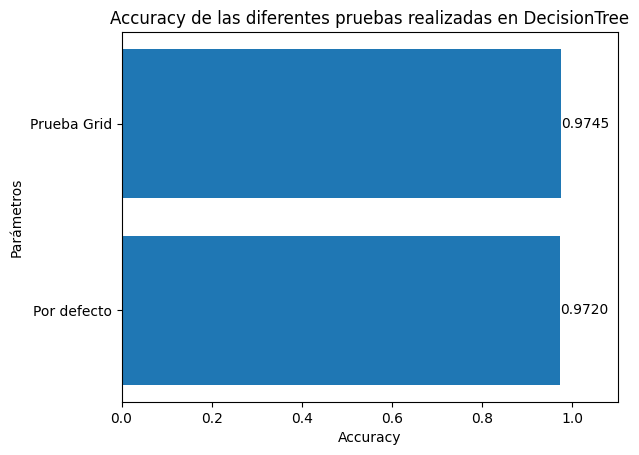

In [165]:
accuracys=[rf_fs.score(X_test_fs, y_validation),
           score_rf]
pruebas = ["Por defecto", "Prueba Grid"]

fig, ax = plt.subplots()
bars = ax.barh(pruebas,accuracys)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Parámetros')
ax.set_title('Accuracy de las diferentes pruebas realizadas en DecisionTree')
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.4f}', 
             va='center', ha='left')
ax.set_xlim(0, 1.1)
plt.show()

Nuevamente, la configuración hallada por GridSearch es la mejor, aunque esta vez el aumento es muy ínfimo en relación al tiempo y los recursos que utilizamos para correr este algoritmo.

## Redes Neuronales
### Pruebas con parámetros por defecto
Como anteriormente se realizó el entrenamiento del modelo con los parámetros por defecto, veremos el score, el reporte de clasificación y la matriz de confusión.

In [166]:
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.3f}'.format(mlp_fs.score(X_train_fs_scaler, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.3f}'.format(mlp_fs.score(X_test_fs_scaler, y_validation)))

Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.000
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.977


In [167]:
y_pred_test = mlp_fs.predict(X_test_fs_scaler)
y_pred_train = mlp_fs.predict(X_train_fs_scaler)

print("Reporte de clasificación entrenamiento: ")
print(classification_report(y_train, y_pred_train))
print("==============================================================")
print("Reporte de clasificación prueba: ")
print(classification_report(y_validation, y_pred_test))

Reporte de clasificación entrenamiento: 
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      3000
         1.0       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Reporte de clasificación prueba: 
              precision    recall  f1-score   support

        -1.0       0.97      0.98      0.98       500
         1.0       0.98      0.97      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



El puntaje por defecto es el mejor entre todos los modelos que hemos podido evaluar con el conjunto de datos de FS(Prueba 2), lo cual es muy prometedor considerando que no está todavía optimizado con GridSearch.

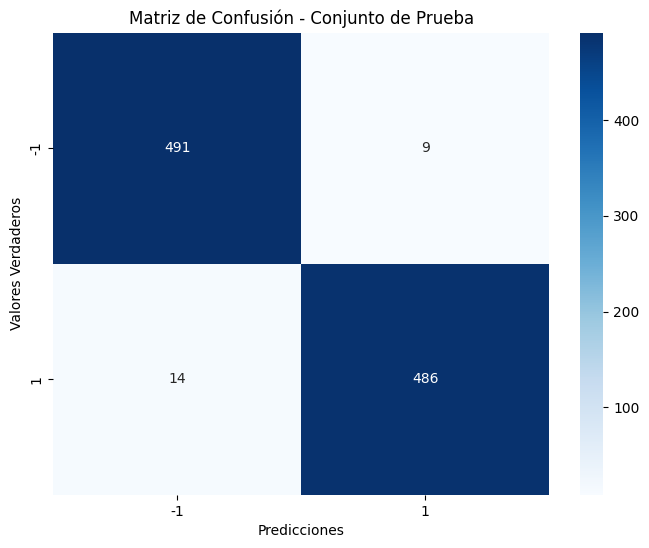

In [168]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

Arriba podemos ver la matriz de confusión del modelo de redes neuronales por defecto.

### Prueba de parámetros con Grid Search
Con fines de eficiencia computacional, realizaremos una sola prueba de GridSearch con suficientes hiperparámetros para poder tomar el mejor score y los mejores parámetros.

In [169]:
param_grid = {
    'hidden_layer_sizes': [(10),(20,20),(50,50,50),(100,100,100,50),(10,10,10),(50,50,50,50,50),(100,100,100,100,100)],
    'max_iter': [300,500,1000],
    'alpha':[0.0001, 0.001, 0.01,0.1]}

model = neural_network.MLPClassifier()
grid_search = GridSearchCV(model, param_grid,cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train_fs_scaler, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [10, (20, 20), (50, 50, 50),
                                                (100, 100, 100, 50),
                                                (10, 10, 10),
                                                (50, 50, 50, 50, 50),
                                                (100, 100, 100, 100, 100)],
                         'max_iter': [300, 500, 1000]},
             scoring='accuracy')

In [173]:
best_params_mlp = grid_search.best_params_
print(best_params_mlp)
score_mlp = grid_search.best_score_
print("Best score:",score_mlp)

{'alpha': 0.1, 'hidden_layer_sizes': (50, 50, 50), 'max_iter': 500}
Best score: 0.9836666666666666


In [174]:
predictions = grid_search.predict(X_test_fs_scaler)
print("Accuracy:",accuracy_score(y_validation, predictions))

Accuracy: 0.975


In [175]:
y_pred_train = grid_search.predict(X_train_fs_scaler)
y_pred_test  = grid_search.predict(X_test_fs_scaler)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_validation, y_pred_test))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      3000
         1.0       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

----------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.97      0.98      0.98       500
         1.0       0.98      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.97      0.97      1000



De nuevo el cambio en la precisión, recall y f1 son ínfimos considerando el tiempo y los recursos computacionales que hemos utilizado, sin embargo esto es un testamento de lo robusto que es este modelo ya por defecto, con los datos de entrenamiento que hemos suministrado.

## Resultados Finales con parámetros ajustados
### Decision Tree

In [187]:
clf = tree.DecisionTreeClassifier(criterion=best_params_clf3['criterion'],
                                  max_depth=best_params_clf3['max_depth'],
                                  min_samples_leaf=best_params_clf3['min_samples_leaf'],
                                  min_samples_split=best_params_clf3['min_samples_split'])
clf = clf.fit(X_train_fs,y_train)
y_pred_clf = clf.predict(X_test_fs)
print('=========================== ACCURACY ===========================')
print('Accuracy de DecisionTreeClasifier sobre el conjunto de entrenamiento es: {:.4f}'.format(clf.score(X_train_fs, y_train)))
print('Accuracy de DecisionTreeClasifier sobre el conjunto de prueba es: {:.4f}'.format(clf.score(X_test_fs, y_test))) 

=========================== ACCURACY ===========================
Accuracy de DecisionTreeClasifier sobre el conjunto de entrenamiento es: 0.9693
Accuracy de DecisionTreeClasifier sobre el conjunto de prueba es: 0.9280


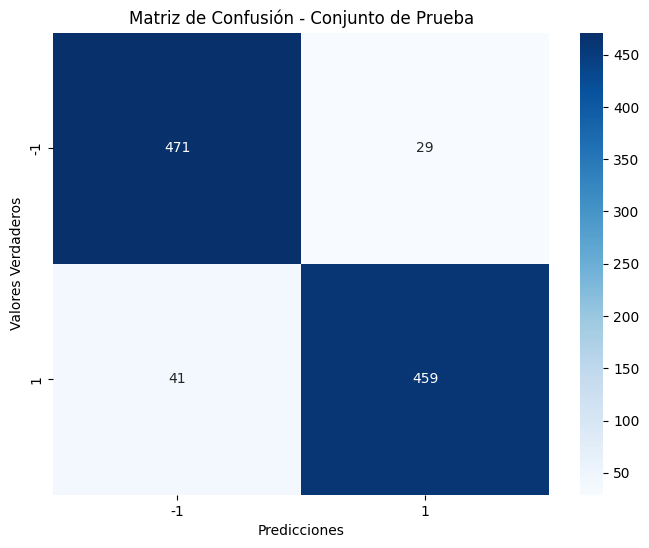

In [184]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_clf)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

La matriz de confusión nos indica que DecisionTree es el algoritmo mas inconsistente entre los 3 utilizados, pero los resultados siguen siendo favorables.

### Random Forest

In [189]:
rf = ensemble.RandomForestClassifier(criterion=best_params_rf['criterion'],
                                  max_depth=best_params_rf['max_depth'],
                                  min_samples_leaf=best_params_rf['min_samples_leaf'],
                                  min_samples_split=best_params_rf['min_samples_split'],
                                  n_estimators=best_params_rf['n_estimators'])
rf = rf.fit(X_train_fs,y_train)
y_pred_rf = rf.predict(X_test_fs)
print('=========================== ACCURACY ===========================')
print('Accuracy de RandomForest sobre el conjunto de entrenamiento es: {:.4f}'.format(rf.score(X_train_fs, y_train)))
print('Accuracy de RandomForest sobre el conjunto de prueba es: {:.4f}'.format(rf.score(X_test_fs, y_test)))

=========================== ACCURACY ===========================
Accuracy de RandomForest sobre el conjunto de entrenamiento es: 1.0000
Accuracy de RandomForest sobre el conjunto de prueba es: 0.9720


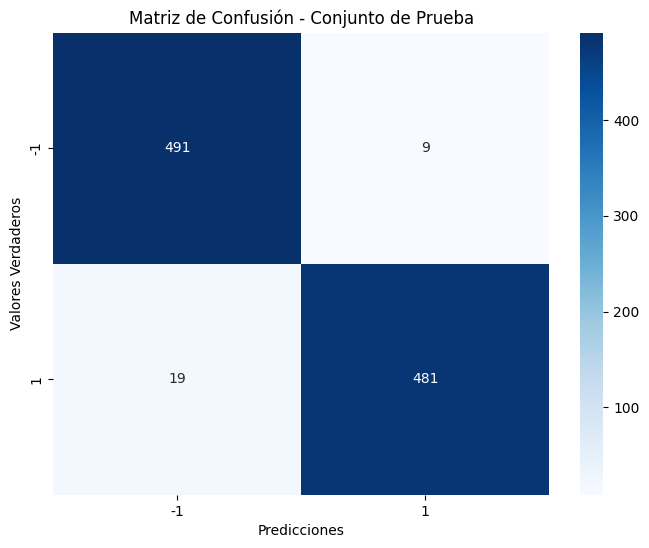

In [190]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_rf)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

Resultados muy robustos, aunque tiende a equivocarse con los falsos positivos de clasificación 1(Es un nueve) mas que con los falsos positivos de clasificación -1(Es un cuatro).

### Redes Neuronales

In [198]:
mlp = neural_network.MLPClassifier(alpha=best_params_mlp['alpha'],
                                  hidden_layer_sizes=best_params_mlp['hidden_layer_sizes'],
                                  max_iter=best_params_mlp['max_iter'])
mlp = mlp.fit(X_train_fs_scaler,y_train)
y_pred_mlp = mlp.predict(X_test_fs_scaler)
print('=========================== ACCURACY ===========================')
print('Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: {:.4f}'.format(mlp.score(X_train_fs_scaler, y_train)))
print('Accuracy de MLPClassifier sobre el conjunto de prueba es: {:.4f}'.format(mlp.score(X_test_fs_scaler, y_test))) 

=========================== ACCURACY ===========================
Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: 1.0000
Accuracy de MLPClassifier sobre el conjunto de prueba es: 0.9800


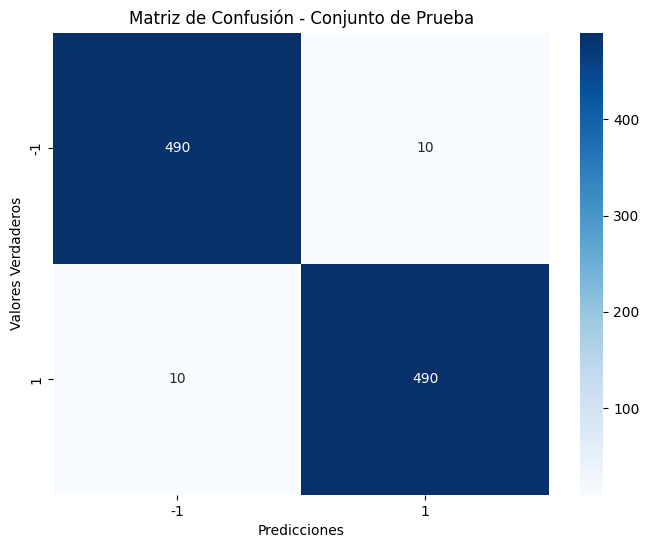

In [199]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_mlp)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

Muy buenos resultados. El algoritmo no se especializa en ninguna clase y tiende a acertar ambos verdaderos positivos de ambas clasificaciones(1 y -1) por igual.

## Análisis de los resultados

Los tres métodos obtienen muy buenos accuracy acercandose casi a 0.95 en caso del Arbol de Decisiones y a 1.0 en el caso de Random Forest y Redes Neuronales con el conjunto de datos de prueba luego de haber realizado una selección de características(Prueba 2) y una búsqueda de mejores hiperparámetros por medio de GridSearch para optimizarlo aún mas.

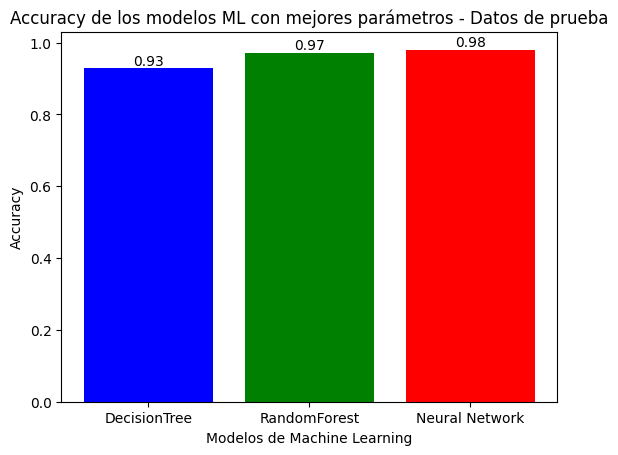

In [202]:
bars=plt.bar(["DecisionTree","RandomForest","Neural Network"], 
        [clf.score(X_test_fs, y_test),rf.score(X_test_fs, y_test),mlp.score(X_test_fs_scaler, y_test)], 
        color=['blue','green','red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.xlabel('Modelos de Machine Learning')
plt.ylabel('Accuracy')
plt.title('Accuracy de los modelos ML con mejores parámetros - Datos de prueba')
plt.show()

Se puede observar también claramente que con los mejores hiperparámetros DecisionTrees no llega a su precisión absoluta(100%) con el conjunto de datos de entrenamiento, a comparación del modelo con los parámetros por defecto. Esto nos indica que a algunas hojas les faltaría una mayor pureza.

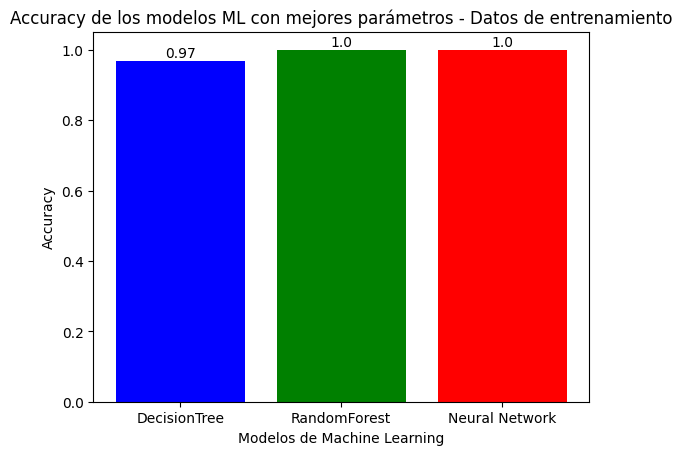

In [203]:
bars=plt.bar(["DecisionTree","RandomForest","Neural Network"], 
        [clf.score(X_train_fs, y_train),rf.score(X_train_fs, y_train),mlp.score(X_train_fs_scaler, y_train)], 
        color=['blue','green','red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.xlabel('Modelos de Machine Learning')
plt.ylabel('Accuracy')
plt.title('Accuracy de los modelos ML con mejores parámetros - Datos de entrenamiento')
plt.show()

Teniendo en cuenta lo anterior, probablemente este sería el motivo por el cual el accuracy del modelo de Arbol de Decisiones no sobrepasa al accuracy con los parámetros por defecto. A pesar de esto, podemos afirmar que la falta de pureza en las hojas se podría solucionar al usar una mejor selección de híperparámetros por medio de Grid Search.

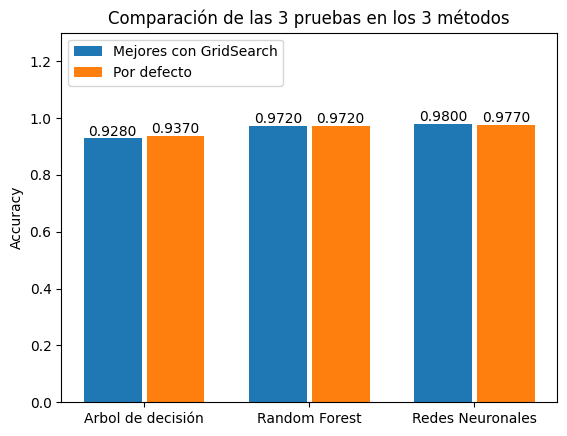

In [211]:
fig, ax = plt.subplots()
rects1=ax.bar(np.arange(3)-0.19,
              [clf.score(X_test_fs, y_test),rf.score(X_test_fs, y_test),mlp.score(X_test_fs_scaler, y_test)],
              0.35,label="Mejores con GridSearch")
rects2=ax.bar(np.arange(3)+0.19,[clf_score_fs,rf_score_fs,mlp_score_fs],0.35,label="Por defecto")

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, '%.4f' % height, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["Arbol de decisión","Random Forest","Redes Neuronales"])
ax.legend(loc='upper left')
ax.set_ylim(0, 1.3)
plt.title("Comparación de las 3 pruebas en los 3 métodos")

plt.show()

## Conclusiones

A partir de los resultados obtenidos podemos concluir:
* El algoritmo de PCA ayuda a reducir carácteristicas de manera rapida a intuitiva, cosa que es muy importante si disponemos de muchas carácteristicas basura que necesitamos eliminar cuanto antes, pero el hecho de basarse en rangos de datos y no poder elegir las carácterísticas especificas que vamos a eliminar perjudica mucho su precisión. En nuestras pruebas, la prueba que utiliza solo PCA(Prueba 1) fue la peor de todas en todos los modelos a excepción del modelo de red neuronal.
* El algoritmo de FS con correlación usado por si mismo(Prueba 2) es muy efectivo y nos permite de tener más control sobre las carácterísticas que vamos a conservar. Posicionandose en primer lugar con todos los tres modelos, esta es sin duda la mejor configuración para este tipo de problemas que dependen mucho de la selección de carácteristicas, esto también significa que son muy sensibles en cuanto a lo que concierne la configuración del umbral, ya que un umbral muy bajo puede causar que se seleccionen demasiadas carácterísticas que posiblemente no tengan un gran impacto en la predicción y uno muy alto causa un sobreajuste al tener une pequeña muestra de entrenamiento.
* El algoritmo que combina PCA y FS(Prueba 3) no logra aprovechar la combinación de ambas fortalezas a la perfección, pues no llega a obtener los mejores resultados, siendo siempre la segunda opción o incluso la última en el modelo de redes neuronales con la configuración que utilizamos.
* GridSearch ayuda a mejorar el modelo con respecto a los parámetros que las librerías entregan por defecto, siempre y cuando los híperparámetros que se le entreguen sean acertados y puestos con fundamento, esta tarea depende mucho del buen criterio del programador.

### Cosas a mejorar


Estamos satisfechos con nuestros experimentos, sin embargo hay una serie de cosas que pudieron mejorarse o suceder para permitir el desarrollo de una configuración mas óptima, entre ellas:

* Disponer de mejores recursos computacionales, pues muchas veces estos códigos demoraban de 15 minutos a 4 horas en ejecutarse dependiendo de la complejidad y el numero de iteraciones con las que se contaba.
* El dataset al ser aumentado de dimensiónes, contiene muchas carácteristicas basura que no son necesarias y no influencian la predicción de las variables. Si esto no fuera así, es posible que se hubieran obtenido mejores resultados
* Los pixeles indicados en el dataset no conforman algún tipo de orden, de lo contrario hubiera sido posible reconstruir la imagen para saber la clasificación de esta, lo cual es importante porque el conjunto de datos que se supone que se usan para pruebas, no cuenta con algún label o variable a predecir que nos ayude a saber si estos son un cuatro o un nueve. Por esta misma razón, el conjunto de pruebas no se pudo utilizar en los experimentos, haciendo que usaramos los datos de validación a fines de prueba ya que estos si disponen de labels.
* El dataset pudo haber sido más grande con menos carácteristicas, dando la posibilidad de experimentar más con diferentes particiones en vez de concentrar los esfuerzos del algoritmo a la etapa de reducción de carácteristica en aras de obtener un buen resultado.
* Si se contara con mejores recursos computacionales, muy posiblemente se hubieran encontrado mejores Hiperparámetros por medio de ensayo y error al momento de hacer pruebas con GridSearch.
* Para el algoritmo de DecisionTree, se pudo haber experimentado con más y mejores híperparámetros ya que incluso la configuración por defecto de la librería logra tener una mejor precisión respecto al modelo que ejecutamos con los mejores híperparámetros hallados por GridSearch.
* Con respecto a los resultados obtenidos en el conjunto de entrenamiento pudimos haber "desajustado" el modelo, es decir buscar hiperparámetros que si bien disminuyen la precisión evaluada en el conjunto de entrenamiento, quizás hubieran ayudado a que el conjunto de prueba llegara a una precisión ligeramente más alta.



## Bibliografía

* https://archive.ics.uci.edu/dataset/170/gisette
* https://proceedings.neurips.cc/paper/2004/file/5e751896e527c862bf67251a474b3819-Paper.pdf
* https://en.wikipedia.org/wiki/MNIST_database
* https://en.wikipedia.org/wiki/Conference_on_Neural_Information_Processing_Systems
* https://statsandr.com/blog/pearson-spearman-kendall-correlation-by-hand/
* Puth, M.-T., Neuhäuser, M., & Ruxton, G. D. (2015). Effective use of Spearman’s and Kendall’s correlation coefficients for association between two measured traits. Animal Behaviour, 102, 77–84. doi:10.1016/j.anbehav.2015.01.010 

